# Телеком

## **Постановка задачи:**

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. <br />
Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).<br />

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.



### Задача

На основании предоставленных данных построить модель со значением ROC-AUC >= 0.85. 

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## **План работы**

1.	**Исследовательский анализ**<br />
        1.1. Загрузка данных<br />
        1.2. Анализ каждого из датасетов<br />
        1.3. Приведение типов<br />
        1.4. Создание необходимых столбцов<br />
2.	**Предобработка данных**<br />
    2.1. Объединение датасетов<br /> 
    2.2. Заполнение пустых значений<br />
    2.3. Выделение признаков и целевого признака<br />
    2.4. Разбивка на обучающую и тестовую выборки<br />
    2.5. Отбор признаков с низкой корелляцией<br />
    2.6. Масштабирование числовых признаков<br />
    2.7. OHE категориальных признаков<br />
    2.8. Устранение дисбаланса классов<br />
3.	**Моделирование**<br />
    3.1. Выбор моделей <br />
    3.2. Выбор дополнительных метрик<br />
    3.3. Подбор гиперпараметров<br />
    3.4. Моделирование<br />
    3.5. Выбор наилучшей модели с учётом ROC-AUC и дополнительных метрик на кросс-валидации<br />
4.	**Тестирование**<br />
    4.1. Тестирование наилучшей модели на тестовой выборке<br />
    4.2. Исследование важности признаков лучшей модели<br />
    4.3. Построение матрицы ошибок<br />
5.	**Отчёт**


## **Подготовительные работы**

### Импорт библиотек

In [1]:
!pip install imbalanced-learn
!pip install phik
!pip install shap

In [2]:
import datetime
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import shap
import statistics 
import warnings

from datetime import datetime
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier
from phik import phik_matrix
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.tree import DecisionTreeClassifier

In [3]:
# Отключение warning
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

#Формат float
pd.options.display.float_format = '${:,.2f}'.format

# Сброс ограничений на число столбцов
pd.options.display.max_columns = None

Константы:

In [4]:
TRH = 0.9 # Порог корреляции

### Функция получения информации о столбце

In [5]:
def col_reaper(ddf,param_name,plot_hist = True,  data_fields = {}):
    #global data_fields
    data_len = len(ddf)
    param = ddf[param_name]
    
    #Определение имени столбца
    if data_fields.get(param_name)[0] is not None:
        field = data_fields.get(param_name)[0]
    else:
        field = ''
        
    #Описание данных
    print('')
    print('\033[4m'+'Описание данных:'+ '\033[0m')
    print(param.describe(datetime_is_numeric=True))
    typer = type(param[0])
    print('\033[4m' +  'Количество записей:' + '\033[0m', sum(param.notna()), 'из', data_len)
    if sum(param.isna()) >0:
       print('\033[4m' +  'Пропущено:' + '\033[0m', sum(param.isna()))
       print('')

    #Построение гистограммы
    print('\033[4m'+'\nТип:\n' + '\033[0m', typer)
    if plot_hist and not 'str' in str(typer):
            print('\033[4m'+'\nГистограмма значений:'+ '\033[0m')
            param.plot(kind='hist',bins=50,figsize=(16,5), grid = True)
            plt.title(field)
            #plt.xlabel('Населенные пункты') 
            plt.ylabel('Количество записей')
            plt.xticks(rotation=0)
            plt.show()
            
    else:
        if len(param.unique())<=40:
            #param_index = param.reset_index()
            print('\033[4m'+'\nРаспределение уникальных значений (первые 10 значений в порядке убывания):'+ '\033[0m')
            param_group=ddf.groupby(param_name).agg(cnt=(param_name,'count')).reset_index()
            display(param_group.sort_values(by='cnt',ascending=False).reset_index(drop=True).head(10))
            
            print('\033[4m'+'\nГистограмма значений:'+ '\033[0m')
            param_group.plot(x=param_name, y='cnt', kind='bar',figsize=(16,5))
            plt.title(field)
            plt.xlabel('') 
            plt.ylabel('Количество записей')
            if len(param.unique())<=20:
                plt.xticks(rotation=0)
            else:
                plt.xticks(rotation=90)
            plt.show()
    print('')
    

### Функция получения информации о датафрейме

In [6]:
def df_reaper(df, df_name ='', data_fields = {}):
    
    # Список столюцов для гистограмм, диаграмм, корелляции и т.п.
    cols = df.columns
#    print(cols)
    true_cols = []
    for col in cols:
        if data_fields.get(col)[1]:
            true_cols.append(col)

    print('\033[1;4m' +  df_name + '\033[0m \n')   
    print('\033[1m' +  'Количество записей:' + '\033[0m')   
    df_len = len(df)
    display(df_len)
    print('')
    
    print('\033[1m' +  'Первые 5 строк данных:' + '\033[0m')   
    display(df.head())
    print('')
    
    print('\033[1m' +  'Информация о датафрейме:' + '\033[0m')
    print('')
    display(df.info())
    
    print('\033[1m' +  'Описание данных в столбцах с числовыми значениями:' + '\033[0m')
    display(df.describe().T)

    print('\033[1m' +  'Столбцы:' + '\033[0m \n')
 
    for col in cols:
        if data_fields.get(col)[0] is not None:
            field = data_fields.get(col)[0]
        else:
            field = ''
        print('\033[1;3m' +  col + ' - ' + field + '\033[0m')
        plot_hist = data_fields.get(col)[1]
        col_reaper(df,col,plot_hist, data_fields)

## **Исследовательский анализ**

### **Загрузка данных**

 Информация о договорах:

In [7]:
try:
    contracts = pd.read_csv('datasets/contract_new.csv')
except:
    contracts = pd.read_csv('/datasets/contract_new.csv')

Персональные данные клиентов:

In [8]:
try:
    personal = pd.read_csv('datasets/personal_new.csv')
except:
    personal = pd.read_csv('/datasets/personal_new.csv')

Информация об интернет-услугах:

In [9]:
try:
    internet = pd.read_csv('datasets/internet_new.csv')
except:
    internet = pd.read_csv('/datasets/internet_new.csv')

Информация об услугах телефонии:

In [10]:
try:
    phone = pd.read_csv('datasets/phone_new.csv')
except:
    phone = pd.read_csv('/datasets/phone_new.csv')

### **"Информация о договорах"**

#### Анализ данных датасета

In [11]:
contracts_data_name = 'Информация о договорах'
contracts_data_fields = {
    'customerID': ['Уникальный идентификатор пользователя', False],
    'BeginDate': ['Дата подписания контракта', False],
    'EndDate': ['Дата закрытия контракта', False],
    'Type': ['Тип контракта', True],
    'PaperlessBilling': ['Безбумажное выставление счетов', True],
    'PaymentMethod': ['Способ оплаты', True],
    'MonthlyCharges': ['Средний ежемесячный платеж', True],
    'TotalCharges': ['Сумма всех платежей', True]
    }

Информация о договорах: 

Количество записей:


7043


Первые 5 строк данных:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,$29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,$56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,$53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),$42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,$70.70,353.5



Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

Описание данных в столбцах с числовыми значениями:


,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,"$7,043.00",$64.76,$30.09,$18.25,$35.50,$70.35,$89.85,$118.75


Столбцы: 

customerID - Уникальный идентификатор пользователя

Описание данных:
count           7043
unique          7043
top       7590-VHVEG
freq               1
Name: customerID, dtype: object
Количество записей: 7043 из 7043

Тип:
 <class 'str'>

BeginDate - Дата подписания контракта

Описание данных:
count           7043
unique            77
top       2014-02-01
freq             366
Name: BeginDate, dtype: object
Количество записей: 7043 из 7043

Тип:
 <class 'str'>

EndDate - Дата закрытия контракта

Описание данных:
count     7043
unique      67
top         No
freq      5942
Name: EndDate, dtype: object
Количество записей: 7043 из 7043

Тип:
 <class 'str'>

Type - Тип контракта

Описание данных:
count               7043
unique                 3
top       Month-to-month
freq                3875
Name: Type, dtype: object
Количество записей: 7043 из 7043

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,Type,cnt
0,Month-to-month,3875
1,Two year,1695
2,One year,1473



Гистограмма значений:


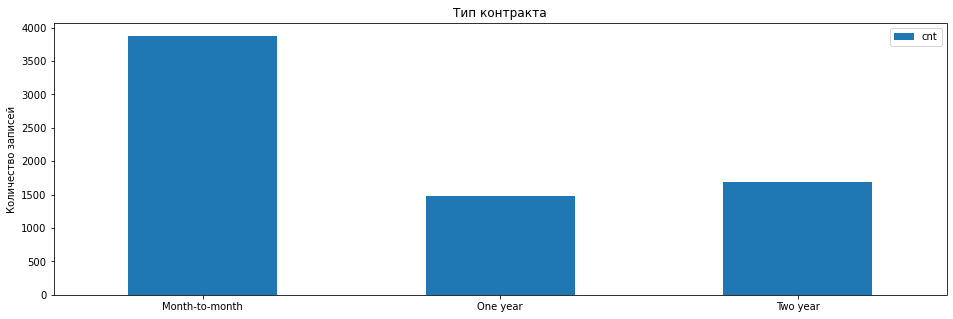


PaperlessBilling - Безбумажное выставление счетов

Описание данных:
count     7043
unique       2
top        Yes
freq      4171
Name: PaperlessBilling, dtype: object
Количество записей: 7043 из 7043

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,PaperlessBilling,cnt
0,Yes,4171
1,No,2872



Гистограмма значений:


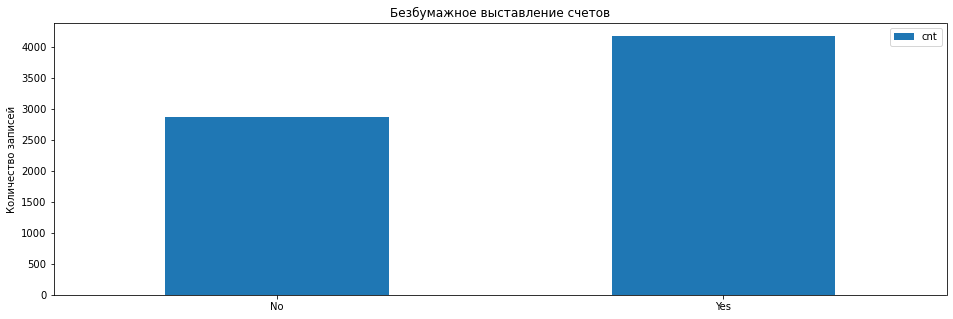


PaymentMethod - Способ оплаты

Описание данных:
count                 7043
unique                   4
top       Electronic check
freq                  2365
Name: PaymentMethod, dtype: object
Количество записей: 7043 из 7043

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,PaymentMethod,cnt
0,Electronic check,2365
1,Mailed check,1612
2,Bank transfer (automatic),1544
3,Credit card (automatic),1522



Гистограмма значений:


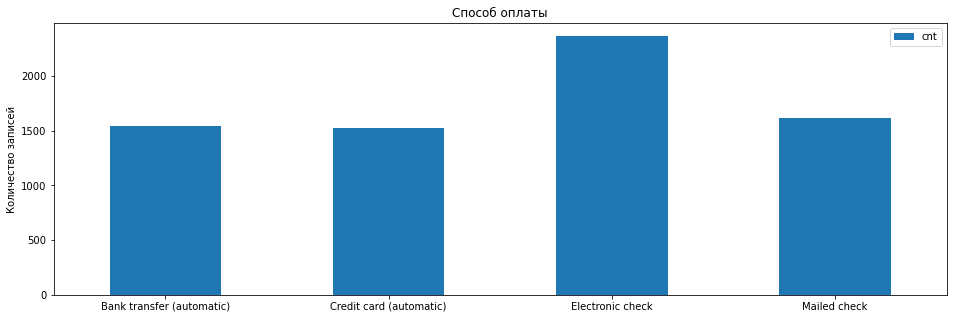


MonthlyCharges - Средний ежемесячный платеж

Описание данных:
count   $7,043.00
mean       $64.76
std        $30.09
min        $18.25
25%        $35.50
50%        $70.35
75%        $89.85
max       $118.75
Name: MonthlyCharges, dtype: float64
Количество записей: 7043 из 7043

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


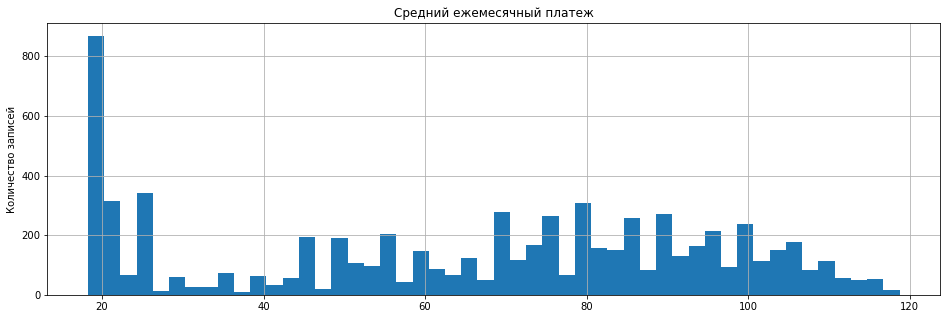


TotalCharges - Сумма всех платежей

Описание данных:
count     7043
unique    6658
top           
freq        11
Name: TotalCharges, dtype: object
Количество записей: 7043 из 7043

Тип:
 <class 'str'>



In [12]:
df_reaper(contracts, 'Информация о договорах:', contracts_data_fields)

Уникальные данные в столбцах, содержащих временные значения:

In [13]:
contracts['BeginDate'].unique()

array(['2020-01-01', '2017-04-01', '2019-10-01', '2016-05-01',
       '2019-09-01', '2019-03-01', '2018-04-01', '2019-04-01',
       '2017-07-01', '2014-12-01', '2019-01-01', '2018-10-01',
       '2015-04-01', '2015-09-01', '2018-01-01', '2014-05-01',
       '2015-10-01', '2014-03-01', '2018-05-01', '2019-11-01',
       '2019-02-01', '2016-01-01', '2017-08-01', '2015-12-01',
       '2014-02-01', '2018-06-01', '2019-12-01', '2017-11-01',
       '2019-06-01', '2016-04-01', '2017-02-01', '2018-12-01',
       '2014-04-01', '2018-09-01', '2014-11-01', '2016-07-01',
       '2015-02-01', '2018-07-01', '2014-08-01', '2016-03-01',
       '2018-08-01', '2014-10-01', '2015-06-01', '2016-08-01',
       '2019-05-01', '2017-03-01', '2016-02-01', '2017-09-01',
       '2014-09-01', '2017-12-01', '2016-12-01', '2017-06-01',
       '2015-05-01', '2016-10-01', '2016-09-01', '2019-08-01',
       '2019-07-01', '2017-05-01', '2017-10-01', '2014-07-01',
       '2018-03-01', '2015-01-01', '2018-11-01', '2015-

In [14]:
contracts['EndDate'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

#### Выводы:

1. Датасет содержит 7043 записи за период с 1 февраля 2014 года по 1 февраля 2020 года, пропуски отсутствуют
2. Каждому пользователю соответствует 1 договор.
3. Столец "BeginDate" содержит строковые значения вместо типа datetime. Данные свёрнуты по месяцам
4. Столбец "EndDate" соделжит смешанные данные (дата и значение 'No', если контракт не закрыт. Данные свёрнуты по месяцам
5. Больше половины пользователей пользуется тарифом с ежемесячной оплатой.
6. Пользователи предпочитают безбумажное выставление счетов и электронную оплату
7. Большая часть пользователей использует дешевые тарифы

<br />

#### Создание дополнительных столбцов:

Имеет смысл сделать дополнительный столбец "Closed", хранящий информацию о том, закрыт контракт или нет (который будет целевым признаком):

In [15]:
def is_closed(row):
    if row['EndDate'] == 'No':
        row['Closed'] = False
        
    else:
        row['Closed'] = True

    return row    

In [16]:
contracts = contracts.apply(is_closed, axis=1)

Преобразование дат в формат DateTime и создание столбца, содержащего длительность контракта

In [17]:
contracts['BeginDate'] = pd.to_datetime(contracts['BeginDate'])

In [18]:
contracts['EndDate'] = contracts['EndDate'].replace('No', '2020-02-01')
contracts['EndDate'] = pd.to_datetime(contracts['EndDate'])

In [19]:
contracts['Duration'] = (contracts['EndDate'] - contracts['BeginDate']).dt.days

In [20]:
contracts.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Closed,Duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,$29.85,31.04,False,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,$56.95,2071.84,False,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,$53.85,226.17,False,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),$42.30,1960.6,False,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,$70.70,353.5,False,153


In [21]:
contracts['Closed'].value_counts(normalize=True)

False   $0.84
True    $0.16
Name: Closed, dtype: float64

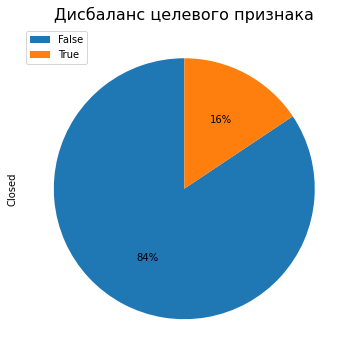

In [22]:
contracts['Closed'].value_counts(normalize=True).plot(kind='pie', y='Closed', autopct='%1.0f%%', 
                                               figsize=(6,6), startangle=90, labeldistance=None)
plt.title('Дисбаланс целевого признака', fontsize=16)
plt.legend()
plt.show()

#### Приведение данных столбца, содержащего строковые значения, к типу bool

In [23]:
contracts['PaperlessBilling'] = contracts['PaperlessBilling'].map({'Yes': True, 'No': False})
contracts['PaperlessBilling'].dtypes

dtype('bool')

#### Итоги:

1. Проведен анализ данных
2. Преобразованы типы столбцов с датами
2. Создан столбец, содержащий длительность действия контрактов
3. Создан столбец "Closed", содержащий целевой признак - статус контракта
3. Соотношение действующих и завершенных контрактов составляет 21:4
4. Столбец PaperlessBilling приведен к типу bool

In [24]:
contracts.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Closed,Duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,True,Electronic check,$29.85,31.04,False,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,False,Mailed check,$56.95,2071.84,False,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,True,Mailed check,$53.85,226.17,False,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,False,Bank transfer (automatic),$42.30,1960.6,False,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,True,Electronic check,$70.70,353.5,False,153


### **"Персональные данные клиента"**

#### Анализ данных датасета

In [25]:
personal_data_name = 'Персональные данные клиента'
personal_data_fields = {
    'customerID': ['Уникальный идентификатор пользователя', False],
    'gender': ['Пол', False],
    'SeniorCitizen': ['Пенсионер', False],
    'Partner': ['В браке', True],
    'Dependents': ['Наличие иждевенцев', True]
    }

Персональные данные клиента: 

Количество записей:


7043


Первые 5 строк данных:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

Описание данных в столбцах с числовыми значениями:


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,"$7,043.00",$0.16,$0.37,$0.00,$0.00,$0.00,$0.00,$1.00


Столбцы: 

customerID - Уникальный идентификатор пользователя

Описание данных:
count           7043
unique          7043
top       7590-VHVEG
freq               1
Name: customerID, dtype: object
Количество записей: 7043 из 7043

Тип:
 <class 'str'>

gender - Пол

Описание данных:
count     7043
unique       2
top       Male
freq      3555
Name: gender, dtype: object
Количество записей: 7043 из 7043

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,gender,cnt
0,Male,3555
1,Female,3488



Гистограмма значений:


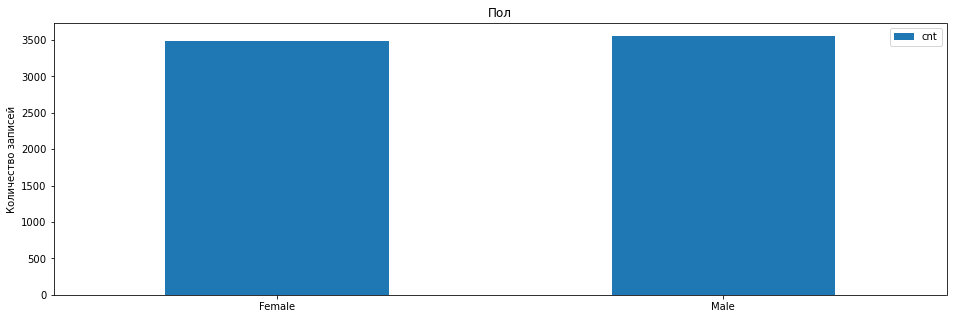


SeniorCitizen - Пенсионер

Описание данных:
count   $7,043.00
mean        $0.16
std         $0.37
min         $0.00
25%         $0.00
50%         $0.00
75%         $0.00
max         $1.00
Name: SeniorCitizen, dtype: float64
Количество записей: 7043 из 7043

Тип:
 <class 'numpy.int64'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,SeniorCitizen,cnt
0,0,5901
1,1,1142



Гистограмма значений:


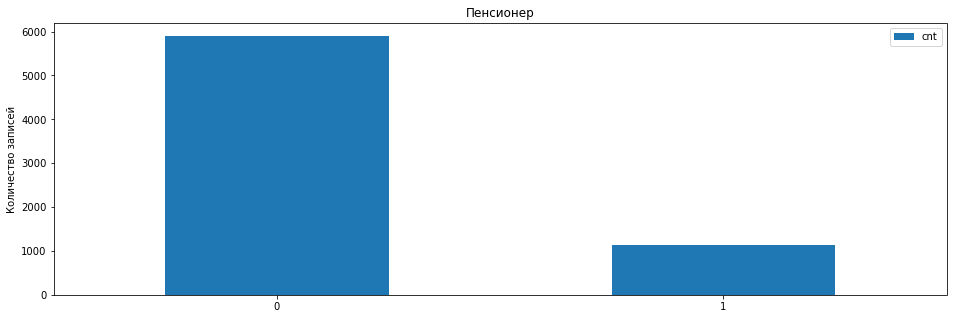


Partner - В браке

Описание данных:
count     7043
unique       2
top         No
freq      3641
Name: Partner, dtype: object
Количество записей: 7043 из 7043

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,Partner,cnt
0,No,3641
1,Yes,3402



Гистограмма значений:


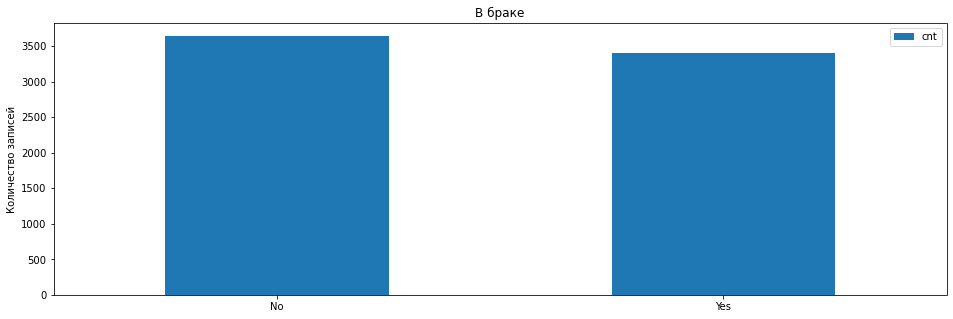


Dependents - Наличие иждевенцев

Описание данных:
count     7043
unique       2
top         No
freq      4933
Name: Dependents, dtype: object
Количество записей: 7043 из 7043

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,Dependents,cnt
0,No,4933
1,Yes,2110



Гистограмма значений:


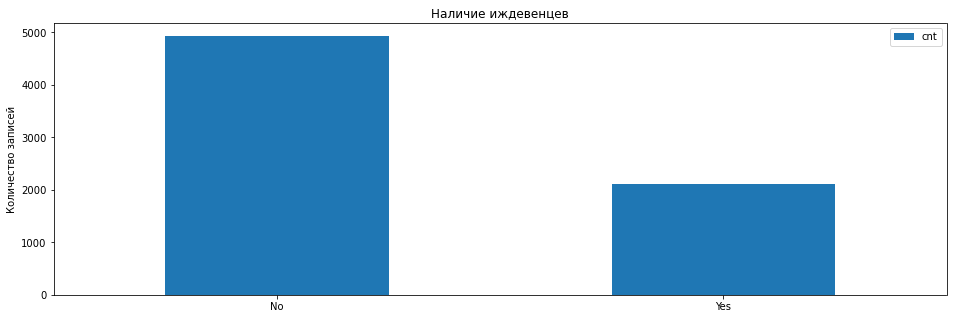

In [26]:
df_reaper(personal, 'Персональные данные клиента:', personal_data_fields)

#### Сравнение списков пользователей

Проверим, что ID  пользователей в контрактах и персональных данных совпадают:

In [27]:
sum(personal['customerID'] != contracts['customerID'])

0

Списки совпали поэлементно!

In [28]:
personal['customerID']

0       7590-VHVEG
1       5575-GNVDE
2       3668-QPYBK
3       7795-CFOCW
4       9237-HQITU
           ...    
7038    6840-RESVB
7039    2234-XADUH
7040    4801-JZAZL
7041    8361-LTMKD
7042    3186-AJIEK
Name: customerID, Length: 7043, dtype: object

In [29]:
contracts['customerID']

0       7590-VHVEG
1       5575-GNVDE
2       3668-QPYBK
3       7795-CFOCW
4       9237-HQITU
           ...    
7038    6840-RESVB
7039    2234-XADUH
7040    4801-JZAZL
7041    8361-LTMKD
7042    3186-AJIEK
Name: customerID, Length: 7043, dtype: object

#### Выводы

1. Датасет содержит записи о 7043 клиентах, что совпадает с количеством контрактов
2. Клиенты в обоих датасетах совпадают, записи, относящиеся к одинаковым клиентам имеют одинаковые индексы
3. Мужчин и женщин примерно поровну
4. Каждый 7-й пользователь - пенсионер
5. Почти половина пользователей находится в браке
6. 2 из 7 пользователей имеет иждивенцев

#### Приведение данных столбцов, содержащих строковые значения, к типу bool

In [30]:
personal[['Partner','Dependents']] = personal[['Partner','Dependents']].applymap(lambda x: True if x == 'Yes' else False)

In [31]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].map({1:True, 0: False})
personal.dtypes

customerID       object
gender           object
SeniorCitizen      bool
Partner            bool
Dependents         bool
dtype: object

#### Итоги:

1. Проведен анализ данных
2. Данные столбцов, содержащих логические значения, приведены к типу bool

In [32]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,False,True,False
1,5575-GNVDE,Male,False,False,False
2,3668-QPYBK,Male,False,False,False
3,7795-CFOCW,Male,False,False,False
4,9237-HQITU,Female,False,False,False


### **"Информация об интернет-услугах"**

#### Анализ данных датасета

In [33]:
internet_data_name = 'Персональные данные клиента'
internet_data_fields = {
    'customerID': ['Уникальный идентификатор пользователя', False],
    'InternetService': ['Тип подключения', True],
    'OnlineSecurity': ['Блокировка небезопасных сайтов', False],
    'OnlineBackup': ['Облачное хранилище файлов для резервного копирования данных', False],
    'DeviceProtection': ['Антивирус', True],
    'TechSupport': ['Сервис технической поддержки', True],
    'StreamingTV': ['Стриминговое телевидение', True],
    'StreamingMovies': ['Каталог фильмов', True]
    }

Персональные данные клиента: 

Количество записей:


5517


Первые 5 строк данных:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

Описание данных в столбцах с числовыми значениями:


,count,unique,top,freq
customerID,5517,5517,7590-VHVEG,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


Столбцы: 

customerID - Уникальный идентификатор пользователя

Описание данных:
count           5517
unique          5517
top       7590-VHVEG
freq               1
Name: customerID, dtype: object
Количество записей: 5517 из 5517

Тип:
 <class 'str'>

InternetService - Тип подключения

Описание данных:
count            5517
unique              2
top       Fiber optic
freq             3096
Name: InternetService, dtype: object
Количество записей: 5517 из 5517

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,InternetService,cnt
0,Fiber optic,3096
1,DSL,2421



Гистограмма значений:


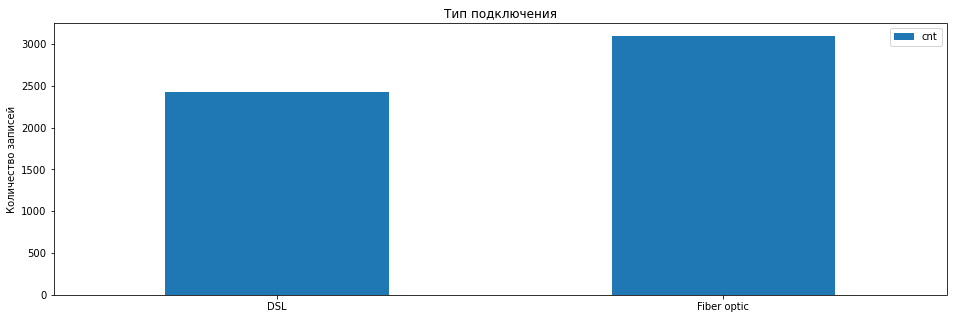


OnlineSecurity - Блокировка небезопасных сайтов

Описание данных:
count     5517
unique       2
top         No
freq      3498
Name: OnlineSecurity, dtype: object
Количество записей: 5517 из 5517

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,OnlineSecurity,cnt
0,No,3498
1,Yes,2019



Гистограмма значений:


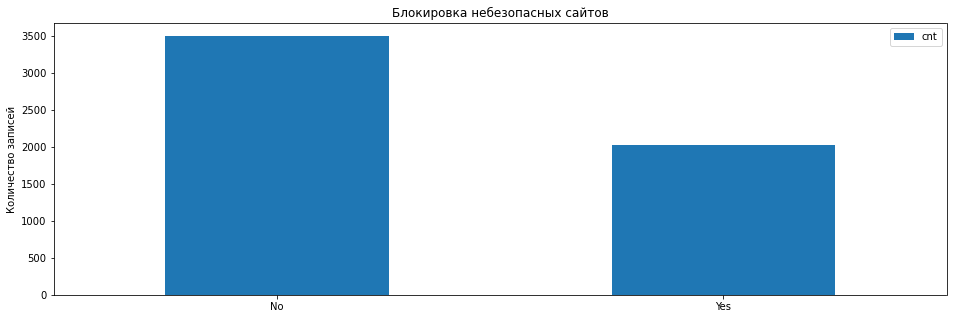


OnlineBackup - Облачное хранилище файлов для резервного копирования данных

Описание данных:
count     5517
unique       2
top         No
freq      3088
Name: OnlineBackup, dtype: object
Количество записей: 5517 из 5517

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,OnlineBackup,cnt
0,No,3088
1,Yes,2429



Гистограмма значений:


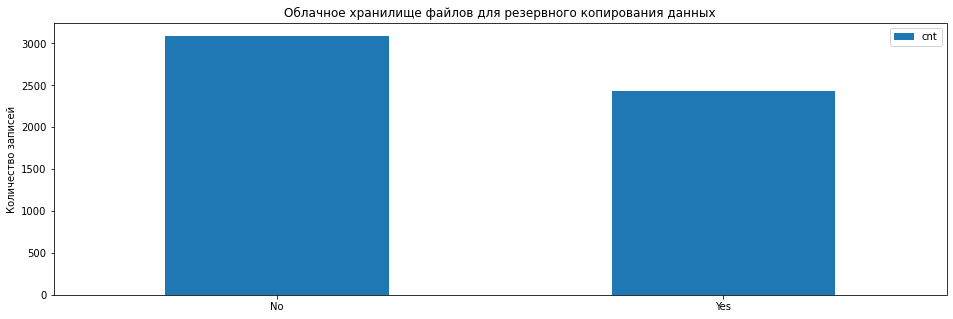


DeviceProtection - Антивирус

Описание данных:
count     5517
unique       2
top         No
freq      3095
Name: DeviceProtection, dtype: object
Количество записей: 5517 из 5517

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,DeviceProtection,cnt
0,No,3095
1,Yes,2422



Гистограмма значений:


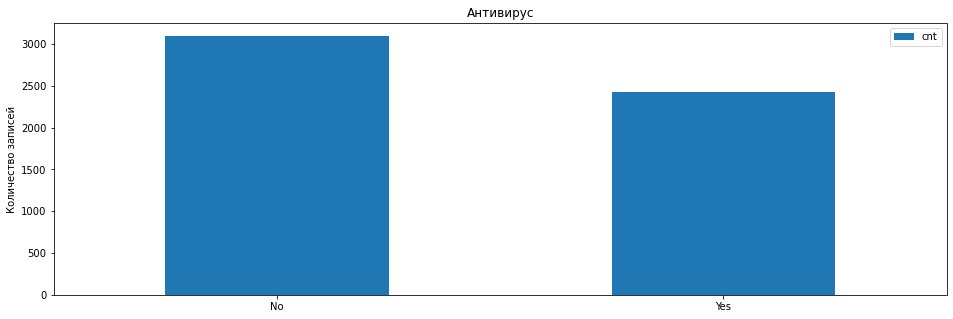


TechSupport - Сервис технической поддержки

Описание данных:
count     5517
unique       2
top         No
freq      3473
Name: TechSupport, dtype: object
Количество записей: 5517 из 5517

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,TechSupport,cnt
0,No,3473
1,Yes,2044



Гистограмма значений:


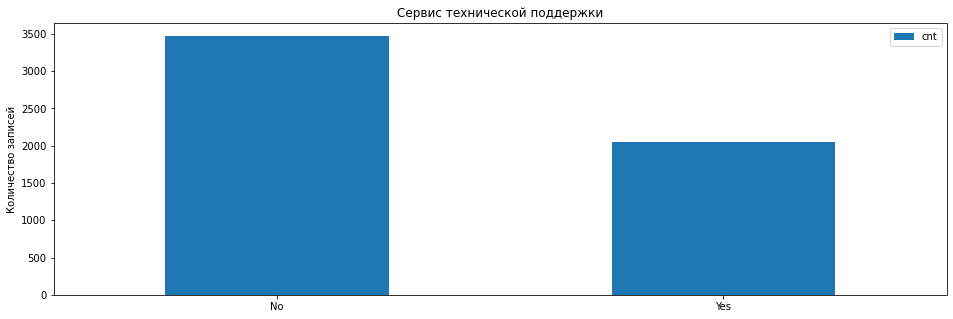


StreamingTV - Стриминговое телевидение

Описание данных:
count     5517
unique       2
top         No
freq      2810
Name: StreamingTV, dtype: object
Количество записей: 5517 из 5517

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,StreamingTV,cnt
0,No,2810
1,Yes,2707



Гистограмма значений:


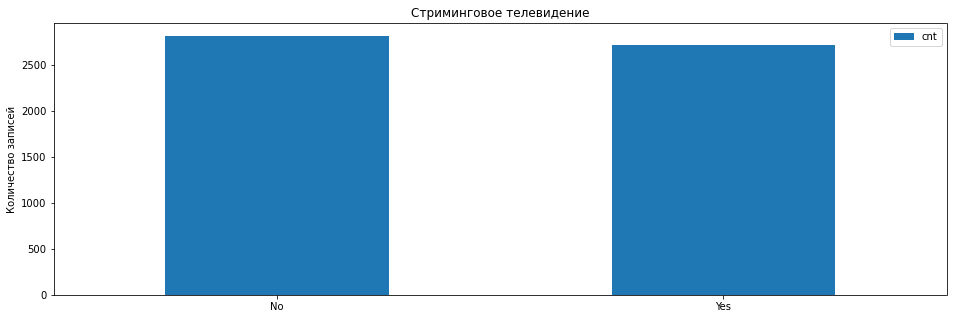


StreamingMovies - Каталог фильмов

Описание данных:
count     5517
unique       2
top         No
freq      2785
Name: StreamingMovies, dtype: object
Количество записей: 5517 из 5517

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,StreamingMovies,cnt
0,No,2785
1,Yes,2732



Гистограмма значений:


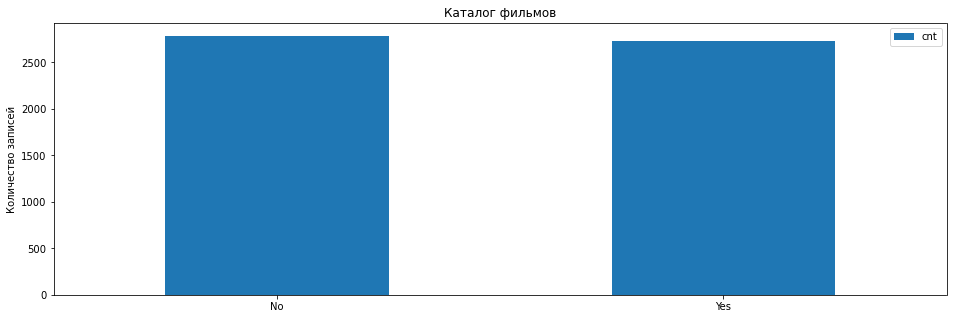

In [34]:
df_reaper(internet, 'Персональные данные клиента:', internet_data_fields)

#### Выводы

1. Датасет содержит записи о 5517 клиентах (из 7043), пользующихся интернет-услугами
2. 60% пользуется оптоволокном, 40 - DSL
3. Примерно по 50% пользуется стриминговым ТВ и каталогом фильмов, остальными услугами большая часть пользователей не пользуется.

#### Создание дополнительного столбца

In [35]:
internet['inet'] = True

#### Приведение данных столбцов, содержащих строковые значения, к типу bool

In [36]:
inet_bool = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

In [37]:
internet[inet_bool] = internet[inet_bool].applymap(lambda x: True if x == 'Yes' else False)
internet.dtypes

customerID          object
InternetService     object
OnlineSecurity        bool
OnlineBackup          bool
DeviceProtection      bool
TechSupport           bool
StreamingTV           bool
StreamingMovies       bool
inet                  bool
dtype: object

#### Итоги:

1. Проведен анализ данных
2. Создан столбец, определяющий, пользуется ли пользователь интернет-услугами
3. Данные столбцов, содержащих логические значения, приведены к типу bool

In [38]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,inet
0,7590-VHVEG,DSL,False,True,False,False,False,False,True
1,5575-GNVDE,DSL,True,False,True,False,False,False,True
2,3668-QPYBK,DSL,True,True,False,False,False,False,True
3,7795-CFOCW,DSL,True,False,True,True,False,False,True
4,9237-HQITU,Fiber optic,False,False,False,False,False,False,True


### **"Информация об услугах телефонии"**

#### Анализ данных датасета

In [39]:
phone_data_name = 'Персональные данные клиента'
phone_data_fields = {
    'customerID': ['Уникальный идентификатор пользователя', False],
    'MultipleLines': ['Многоканальное подключение', True]
    }

Персональные данные клиента: 

Количество записей:


6361


Первые 5 строк данных:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

Описание данных в столбцах с числовыми значениями:


,count,unique,top,freq
customerID,6361,6361,5575-GNVDE,1
MultipleLines,6361,2,No,3390


Столбцы: 

customerID - Уникальный идентификатор пользователя

Описание данных:
count           6361
unique          6361
top       5575-GNVDE
freq               1
Name: customerID, dtype: object
Количество записей: 6361 из 6361

Тип:
 <class 'str'>

MultipleLines - Многоканальное подключение

Описание данных:
count     6361
unique       2
top         No
freq      3390
Name: MultipleLines, dtype: object
Количество записей: 6361 из 6361

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,MultipleLines,cnt
0,No,3390
1,Yes,2971



Гистограмма значений:


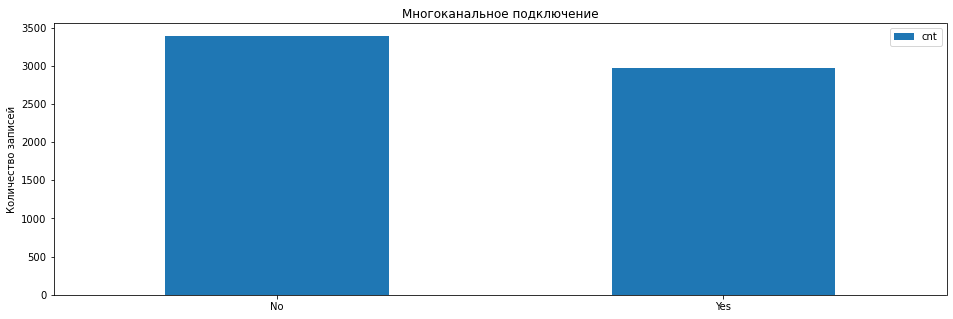

In [40]:
df_reaper(phone, 'Персональные данные клиента:', phone_data_fields)

#### Выводы

1. Датасет содержит записи о 6361 клиентах (из 7043), пользующихся услугами телефонной связи
2. 43% клиентов пользуется мультиканальным подключением

#### Создание дополнительного столбца

In [41]:
phone['phone'] = True

#### Приведение данных столбца, содержащего строковые значения, к типу bool

In [42]:
phone['MultipleLines'] = phone['MultipleLines'].map({'Yes': True, 'No': False})
phone.dtypes

customerID       object
MultipleLines      bool
phone              bool
dtype: object

#### Итоги:

1. Проведен анализ данных
2. Создан столбец, определяющий, пользуется ли пользователь услугами телефонии
3. Данные столбца, содержащего логические значения, приведены к типу bool

In [43]:
phone.head()

,customerID,MultipleLines,phone
0,5575-GNVDE,False,True
1,3668-QPYBK,False,True
2,9237-HQITU,False,True
3,9305-CDSKC,True,True
4,1452-KIOVK,True,True


### **Итоги анализа данных**

#### "Информация о договорах"

**Исходный датасет:**
1. Датасет содержит 7043 записи за период с 1 февраля 2014 года по 1 февраля 2020 года, пропуски отсутствуют
2. Каждому пользователю соответствует 1 договор.
3. Столец "BeginDate" содержит строковые значения вместо типа datetime. Данные свёрнуты по месяцам
4. Столбец "EndDate" соделжит смешанные данные (дата и значение 'No', если контракт не закрыт. Данные свёрнуты по месяцам
5. Больше половины пользователей пользуется тарифом с ежемесячной оплатой.
6. Пользователи предпочитают безбумажное выставление счетов и электронную оплату
7. Большая часть пользователей использует дешевые тарифы
8. Соотношение действующих и завершенных контрактов составляет 21:4
<br />

**Выполненные действия:**
1. Преобразованы типы столбцов с датами
2. Создан столбец, содержащий длительность действия контрактов
3. Создан столбец "Closed", содержащий целевой признак - статус контракта
4. Столбец PaperlessBilling приведен к типу bool

#### "Персональные данные клиента"

**Исходный датасет:**
1. Датасет содержит записи о 7043 клиентах, что совпадает с количеством контрактов
2. Клиенты в обоих датасетах совпадают, записи, относящиеся к одинаковым клиентам имеют одинаковые индексы
3. Мужчин и женщин примерно поровну
4. Каждый 7-й пользователь - пенсионер
5. Почти половина пользователей находится в браке
6. 2 из 7 пользователей имеет иждивенцев
<br />

**Выполненные действия:**<br />
Данные столбцов, содержащих логические значения, приведены к типу bool

#### "Информация об интернет-услугах"

**Исходный датасет:**
1. Датасет содержит записи о 5517 клиентах (из 7043), пользующихся интернет-услугами
2. 60% пользуется оптоволокном, 40 - DSL
3. Примерно по 50% пользуется стриминговым ТВ и каталогом фильмов, остальными услугами большая часть пользователей не пользуется.

**Выполненные действия:**
1. Создан столбец, определяющий, пользуется ли пользователь интернет-услугами
2. Данные столбцов, содержащих логические значения, приведены к типу bool

#### "Информация об услугах телефонии"

**Исходный датасет:**
1. Датасет содержит записи о 6361 клиентах (из 7043), пользующихся услугами телефонной связи
2. 43% клиентов пользуется мультиканальным подключением

**Выполненные действия:**
1. Создан столбец, определяющий, пользуется ли пользователь услугами телефонии
2. Данные столбца, содержащего логические значения, приведены к типу bool

## **Предобработка данных**

**Исходный датасет:**
1. Датасет содержит записи о 5517 клиентах (из 7043), пользующихся интернет-услугами
2. 60% пользуется оптоволокном, 40 - DSL
3. Примерно по 50% пользуется стриминговым ТВ и каталогом фильмов, остальными услугами большая часть пользователей не пользуется.

**Выполненные действия:**
1. Создан столбец, определяющий, пользуется ли пользователь услугами телефонии
2. Данные столбца, содержащего логические значения, приведены к типу bool

### **Формирование во всех датафреймах индекса из столбеца customerID**

In [44]:
contracts.set_index('customerID', inplace=True)

In [45]:
personal.set_index('customerID', inplace=True)

In [46]:
internet.set_index('customerID', inplace=True)

In [47]:
phone.set_index('customerID', inplace=True)

### **Соединение данных в единый датафрейм**

#### Объединение таблиц

In [48]:
data = contracts.join([personal,internet,phone])

In [49]:
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Closed,Duration,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,inet,MultipleLines,phone
customerID,,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,True,Electronic check,$29.85,31.04,False,31,Female,False,True,False,DSL,False,True,False,False,False,False,True,NaN,NaN
5575-GNVDE,2017-04-01,2020-02-01,One year,False,Mailed check,$56.95,2071.84,False,1036,Male,False,False,False,DSL,True,False,True,False,False,False,True,False,True
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,True,Mailed check,$53.85,226.17,False,123,Male,False,False,False,DSL,True,True,False,False,False,False,True,False,True
7795-CFOCW,2016-05-01,2020-02-01,One year,False,Bank transfer (automatic),$42.30,1960.6,False,1371,Male,False,False,False,DSL,True,False,True,True,False,False,True,NaN,NaN
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,True,Electronic check,$70.70,353.5,False,153,Female,False,False,False,Fiber optic,False,False,False,False,False,False,True,False,True


#### Заполнение пустых значений

Количество записей, содержащих пустые значения:

In [50]:
len(data[data.isna().any(axis=1)])

2208

Поскольку все датасеты изначально не содержали пропущенных значений, пустые значения в таблицы образовались только в столбцах интернет- и телефонных услуг у пользователей, которые ими не пользуются. 

В столбце "InternetService" пропущенные значения заменяем на значение 'No internet'

In [51]:
data['InternetService'] = data['InternetService'].fillna('No internet')

Остальные пропущенные значения - в булевых столбцах, поэтому заменяем их на значение False

In [52]:
data = data.fillna(value=False)
len(data[data.isna().any(axis=1)])

0

Все пустые значения заполнены

### **Выделение признаков и целевого признака**

In [53]:
features = data.drop('Closed', axis = 1)
target = data['Closed']

### **Разбивка датасета на обучающую и тестовую выборку**

In [54]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=220523, stratify = target)

In [55]:
features_train.shape

(5282, 22)

In [56]:
features_test.shape

(1761, 22)

In [57]:
features_train = features_train.reset_index(drop=True)
features_test = features_test.reset_index(drop=True)
target_train = target_train.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)

### **Корреляция данных**

#### Функции 

In [58]:
#Построение тепловой карты корелляции
def corr_heatmap_phik(df, title='Коррелляция данных',width = 16, height = 8):    
    plt.figure(figsize=(width, height))
    # Маска на верхний треугольник
    mask = np.triu(np.ones_like(df.phik_matrix(), dtype=np.bool))
    heatmap = sns.heatmap(df.phik_matrix(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title(title, fontdict={'fontsize':12}, pad=16);
    plt.show()

In [59]:
#Вычисление и удаление столбцов с высокой корелляцией
def corr_killer(df,trh):  
    max=1
    while max > trh:
        data_corr=df.phik_matrix()
        for col in df.columns:
            data_corr[col][col] = 0
        data_corr = data_corr.abs()
        sort_corr = data_corr.max().sort_values(ascending=False).reset_index()
        max = sort_corr[0][0]
        if max > trh:
            dead_col = sort_corr['index'][0]
            df=df.drop(dead_col, axis=1)
            
    return df.columns

#### Матрица phik-корреляции 

interval columns not set, guessing: ['MonthlyCharges', 'Duration']
interval columns not set, guessing: ['MonthlyCharges', 'Duration']


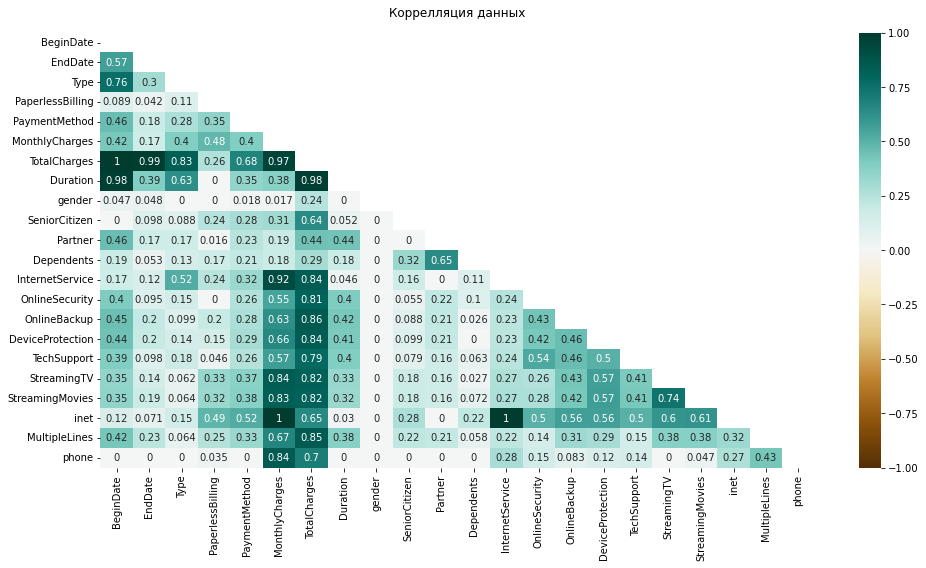

CPU times: total: 3.2 s
Wall time: 1min 47s


In [60]:
%%time
corr_heatmap_phik(features_train)

#### Поиск столбцов с низкой корелляцией

Порог корреляции:

In [61]:
TRH

0.9

In [62]:
%%time
low_corr = corr_killer(features_train,TRH)

interval columns not set, guessing: ['MonthlyCharges', 'Duration']
interval columns not set, guessing: ['MonthlyCharges', 'Duration']
interval columns not set, guessing: ['MonthlyCharges', 'Duration']
interval columns not set, guessing: ['MonthlyCharges', 'Duration']
interval columns not set, guessing: ['MonthlyCharges', 'Duration']
interval columns not set, guessing: ['MonthlyCharges', 'Duration']
CPU times: total: 3.5 s
Wall time: 2min 12s


#### Изменение признаков в обучающей выборке

In [63]:
features_train = features_train[low_corr]
features_train.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,Duration,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,phone
0,Month-to-month,True,Mailed check,$84.65,62,Male,False,False,False,False,False,False,False,True,False,True,True
1,One year,True,Credit card (automatic),$71.10,1767,Female,False,False,False,True,True,True,True,False,False,True,True
2,Two year,False,Mailed check,$45.25,1979,Female,False,False,True,False,True,False,True,True,False,False,False
3,Two year,True,Credit card (automatic),$79.85,1918,Female,False,False,False,True,True,True,True,True,False,True,True
4,Month-to-month,True,Bank transfer (automatic),$101.90,577,Female,False,False,False,False,True,True,False,True,True,True,True


interval columns not set, guessing: ['MonthlyCharges', 'Duration']
interval columns not set, guessing: ['MonthlyCharges', 'Duration']


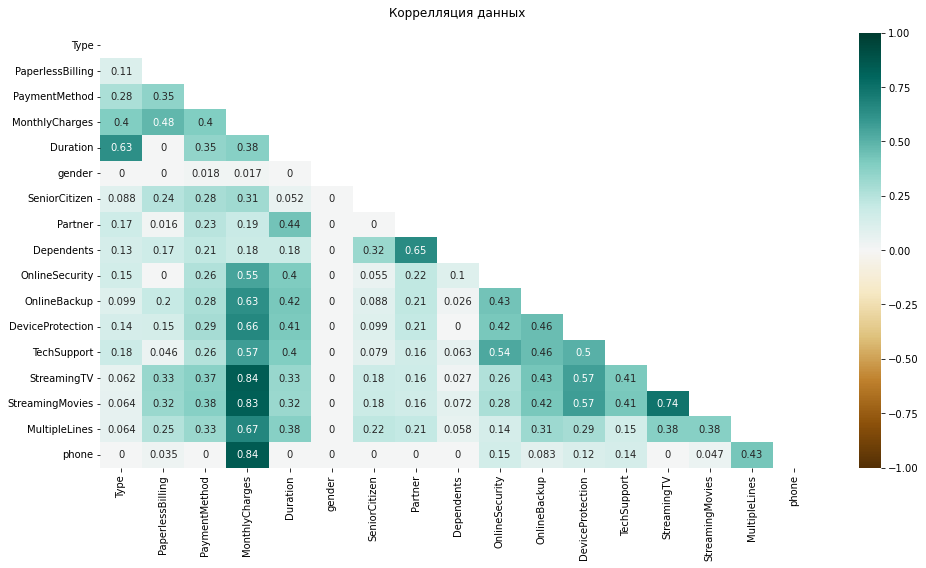

CPU times: total: 2.05 s
Wall time: 2.06 s


In [64]:
%%time
corr_heatmap_phik(features_train)

#### Изменение признаков в тестовой выборке

In [65]:
features_test = features_test[low_corr]
features_test.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,Duration,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,phone
0,Month-to-month,False,Electronic check,$107.55,1006,Female,False,False,False,False,True,True,False,True,True,True,True
1,Month-to-month,True,Electronic check,$63.60,123,Female,False,False,False,False,False,False,True,True,False,True,True
2,Month-to-month,True,Electronic check,$81.15,518,Female,False,False,False,False,True,True,False,False,False,False,True
3,Month-to-month,True,Electronic check,$69.85,92,Female,False,False,False,False,False,False,False,False,False,False,True
4,Month-to-month,True,Mailed check,$18.95,215,Male,False,False,False,False,False,False,False,False,False,False,True


interval columns not set, guessing: ['MonthlyCharges', 'Duration']
interval columns not set, guessing: ['MonthlyCharges', 'Duration']


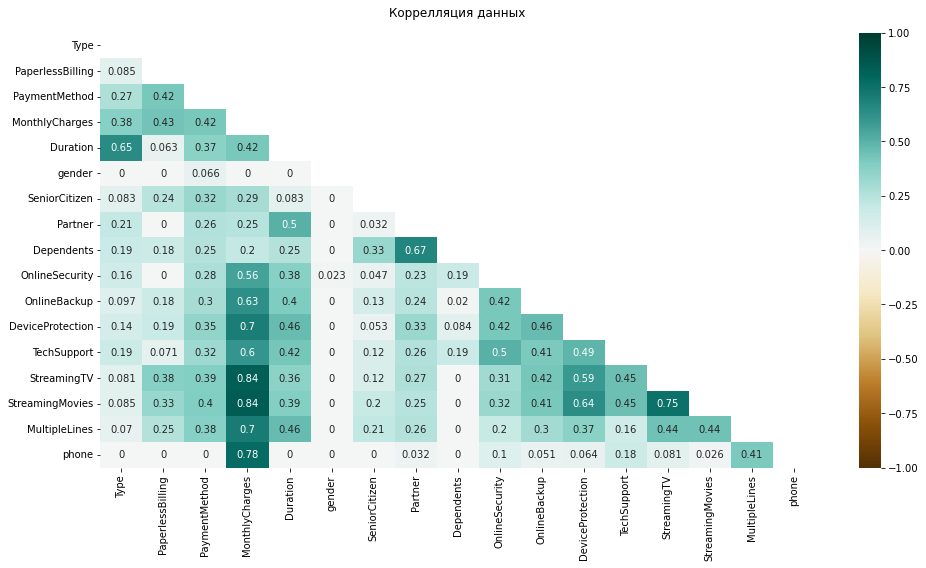

CPU times: total: 1.98 s
Wall time: 2.01 s


In [66]:
%%time
corr_heatmap_phik(features_test)

### **Выделение числовых и категориальных признаков**

In [67]:
features_train.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,Duration,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,phone
0,Month-to-month,True,Mailed check,$84.65,62,Male,False,False,False,False,False,False,False,True,False,True,True
1,One year,True,Credit card (automatic),$71.10,1767,Female,False,False,False,True,True,True,True,False,False,True,True
2,Two year,False,Mailed check,$45.25,1979,Female,False,False,True,False,True,False,True,True,False,False,False
3,Two year,True,Credit card (automatic),$79.85,1918,Female,False,False,False,True,True,True,True,True,False,True,True
4,Month-to-month,True,Bank transfer (automatic),$101.90,577,Female,False,False,False,False,True,True,False,True,True,True,True


Числовые признаки - MonthlyCharges и Duration.<br />

In [68]:
numeric = ['MonthlyCharges', 'Duration']

Все остальные столбцы - категориальные

In [69]:
features_columns = np.array(features_train.columns)
cat_columns = np.delete(features_columns, np.where((features_columns == 'MonthlyCharges')|(features_columns == 'Duration'))) 
cat_columns

array(['Type', 'PaperlessBilling', 'PaymentMethod', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'MultipleLines', 'phone'], dtype=object)

### **Итоги предобработки данных**

1. 4 исходных датасета объединены в единый датафрейм
2. Выделены признаки и целевой признак
3. Датасет разбит на обучающую и тестовую выборку
4. Удалены признаки, значения которых имели высокую корреляцию с другими. 

## **Моделирование**

### PipeLine для **"DummyClassifier"**

Для проверки адекватности моделей будем использовать DummyClassifier

In [70]:
pipeline = make_pipeline(
    ColumnTransformer([
        ('numeric', StandardScaler(), numeric), 
        ('categorical', OneHotEncoder(drop='first', handle_unknown='error', sparse=False), cat_columns)
    ]),
    SMOTE(random_state=220523),
    DummyClassifier(random_state = 220523,constant=1)
)

In [71]:
parameters = {
    'dummyclassifier__strategy':['stratified', 'prior', 'uniform', 'most_frequent'],
}

In [72]:
scoring_metrics = ['roc_auc', 'f1', 'accuracy', 'precision', 'recall']
rs = RandomizedSearchCV(pipeline, 
                        parameters, 
                        n_iter = 5, 
                        scoring = scoring_metrics,
                        refit='roc_auc',
                        cv = 5, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=220523)
rs.fit(features_train, target_train)
model_dm = rs.best_estimator_
model_dm.params = rs.best_params_
result_dm = rs.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [73]:
print('Значения метрик:')
print('AUC-ROC:\t {:.2f}'.format(rs.cv_results_['mean_test_roc_auc'][rs.best_index_]))
print('F1:\t\t {:.2f}'.format(rs.cv_results_['mean_test_f1'][rs.best_index_]))
print('accuracy:\t {:.2f}'.format(rs.cv_results_['mean_test_accuracy'][rs.best_index_]))
print('precision:\t {:.2f}'.format(rs.cv_results_['mean_test_precision'][rs.best_index_]))
print('recall:\t\t {:.2f}'.format(rs.cv_results_['mean_test_recall'][rs.best_index_]))

Значения метрик:
AUC-ROC:	 0.50
F1:		 0.24
accuracy:	 0.52
precision:	 0.16
recall:		 0.48


In [74]:
print('Гиперпараметры лучшей модели:\n', model_dm.params)

Гиперпараметры лучшей модели:
 {'dummyclassifier__strategy': 'stratified'}


### PipeLine для **"LogisticRegression"**

In [75]:
pipeline = make_pipeline(
    ColumnTransformer([
        ('numeric', StandardScaler(), numeric), 
        ('categorical', OneHotEncoder(drop='first', handle_unknown='error', sparse=False), cat_columns)
    ]),
    SMOTE(random_state=220523),
    LogisticRegression(random_state= 220523)
)

In [76]:
parameters = {
    'logisticregression__solver':['liblinear', 'lbfgs','saga'],
}

In [77]:
scoring_metrics = ['roc_auc', 'f1', 'accuracy', 'precision', 'recall']
rs = RandomizedSearchCV(pipeline, 
                        parameters, 
                        n_iter = 5, 
                        scoring = scoring_metrics,
                        refit='roc_auc',
                        cv = 5, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=220523)
rs.fit(features_train, target_train)
model_lr = rs.best_estimator_
model_lr.params = rs.best_params_
result_lr = rs.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [78]:
print('Значения метрик:')
print('AUC-ROC:\t {:.2f}'.format(rs.cv_results_['mean_test_roc_auc'][rs.best_index_]))
print('F1:\t\t {:.2f}'.format(rs.cv_results_['mean_test_f1'][rs.best_index_]))
print('accuracy:\t {:.2f}'.format(rs.cv_results_['mean_test_accuracy'][rs.best_index_]))
print('precision:\t {:.2f}'.format(rs.cv_results_['mean_test_precision'][rs.best_index_]))
print('recall:\t\t {:.2f}'.format(rs.cv_results_['mean_test_recall'][rs.best_index_]))

Значения метрик:
AUC-ROC:	 0.75
F1:		 0.41
accuracy:	 0.69
precision:	 0.29
recall:		 0.67


In [79]:
print('Гиперпараметры лучшей модели:\n', model_lr.params)

Гиперпараметры лучшей модели:
 {'logisticregression__solver': 'liblinear'}


### PipeLine для **"RandomForest"**

In [80]:
pipeline = make_pipeline(
    ColumnTransformer([
        ('numeric', StandardScaler(), numeric), 
        ('categorical', OneHotEncoder(drop='first', handle_unknown='error', sparse=False), cat_columns)
    ]),
    SMOTE(random_state=220523),
    RandomForestClassifier(random_state=220523)
)

In [81]:
parameters = {
            'randomforestclassifier__n_estimators': [10, 20, 30, 40,50],
            'randomforestclassifier__max_depth': [5, 10, 15, 20],
            'randomforestclassifier__min_samples_split': [2, 5, 10, 15],
            'randomforestclassifier__min_samples_leaf': [1, 2, 4, 6],
            'randomforestclassifier__max_features': ['sqrt', 'log2'],
}

In [82]:
scoring_metrics = ['roc_auc', 'f1', 'accuracy', 'precision', 'recall']
rs = RandomizedSearchCV(pipeline, 
                        parameters, 
                        n_iter = 5, 
                        scoring = scoring_metrics,
                        refit='roc_auc',
                        cv = 5, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=220523)
rs.fit(features_train, target_train)
model_rf = rs.best_estimator_
model_rf.params = rs.best_params_
result_rf = rs.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [83]:
print('Значения метрик:')
print('AUC-ROC:\t {:.2f}'.format(rs.cv_results_['mean_test_roc_auc'][rs.best_index_]))
print('F1:\t\t {:.2f}'.format(rs.cv_results_['mean_test_f1'][rs.best_index_]))
print('accuracy:\t {:.2f}'.format(rs.cv_results_['mean_test_accuracy'][rs.best_index_]))
print('precision:\t {:.2f}'.format(rs.cv_results_['mean_test_precision'][rs.best_index_]))
print('recall:\t\t {:.2f}'.format(rs.cv_results_['mean_test_recall'][rs.best_index_]))

Значения метрик:
AUC-ROC:	 0.82
F1:		 0.48
accuracy:	 0.82
precision:	 0.43
recall:		 0.54


In [84]:
print('Гиперпараметры лучшей модели:\n', model_rf.params)

Гиперпараметры лучшей модели:
 {'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 6, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 10}


### PipeLine для **"LightGBM"**

In [85]:
pipeline = make_pipeline(
    ColumnTransformer([
        ('numeric', StandardScaler(), numeric), 
        ('categorical', OneHotEncoder(drop='first', handle_unknown='error', sparse=False), cat_columns)
    ]),
    SMOTE(random_state=220523),
    LGBMClassifier(random_state=220523)
)

In [86]:
parameters = {
            'lgbmclassifier__n_estimators': [40, 80, 120, 160,200],
            'lgbmclassifier__max_depth': [5, 10, 15, 20],
            'lgbmclassifier__boosting_type': ['gbdt','goss'],
            'lgbmclassifier__learning_rate': np.logspace(-3, 0, 100) # Диапазон значений от 0.001 до 1
}

In [87]:
scoring_metrics = ['roc_auc', 'f1', 'accuracy', 'precision', 'recall']
rs = RandomizedSearchCV(pipeline, 
                        parameters, 
                        n_iter = 5, 
                        scoring = scoring_metrics,
                        refit='roc_auc',
                        cv = 5, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=220523)
rs.fit(features_train, target_train)
model_lgbm = rs.best_estimator_
model_lgbm.params = rs.best_params_
result_lgbm = rs.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [88]:
print('Значения метрик:')
print('AUC-ROC:\t {:.2f}'.format(rs.cv_results_['mean_test_roc_auc'][rs.best_index_]))
print('F1:\t\t {:.2f}'.format(rs.cv_results_['mean_test_f1'][rs.best_index_]))
print('accuracy:\t {:.2f}'.format(rs.cv_results_['mean_test_accuracy'][rs.best_index_]))
print('precision:\t {:.2f}'.format(rs.cv_results_['mean_test_precision'][rs.best_index_]))
print('recall:\t\t {:.2f}'.format(rs.cv_results_['mean_test_recall'][rs.best_index_]))

Значения метрик:
AUC-ROC:	 0.86
F1:		 0.52
accuracy:	 0.87
precision:	 0.62
recall:		 0.44


In [89]:
print('Гиперпараметры лучшей модели:\n', model_lgbm.params)

Гиперпараметры лучшей модели:
 {'lgbmclassifier__n_estimators': 160, 'lgbmclassifier__max_depth': 15, 'lgbmclassifier__learning_rate': 0.07564633275546291, 'lgbmclassifier__boosting_type': 'gbdt'}


### **Итоги моделирования**

1. Произведено моделирование с помощью четырех пайплайнов, состоящих из:
- масштабатора StandardScaler для числовых признаков,
- кодировщика OneHotEncoder для категориальных признаков,
- балансиновщика SMOTE,
 а так же одной из моделей:
- DummyClassifier (как меры адекватности моделей),
- LogisticRegression,
- RandomForest,
- LightGBM.
2. Лучший результат показала модель LightGBM с параметрами: 
- 'n_estimators': 160,
- 'max_depth': 15, 
- 'learning_rate': 0.076, 
- 'boosting_type': 'gbdt'
3. Значения метрик лучшей модели на обучающей выборке:
- AUC-ROC: 0.86
- F1:		 0.52
- accuracy:	 0.87
- precision:	 0.62
- recall:		 0.44

## Проверка качества лучшей модели

### Моделирование

Проверим нашу лучшую модель на тестовой выборке:

In [90]:
probabilities_test = model_lgbm.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print('AUC-ROC: {:.2f}'.format(roc_auc_score(target_test, probabilities_one_test)))

AUC-ROC: 0.89


In [91]:
print('Значения метрик:')
print('AUC-ROC:\t {:.2f}'.format(roc_auc_score(target_test, probabilities_one_test)))
predict = model_lgbm.predict(features_test)
print('F1:\t\t {:.2f}'.format(f1_score(target_test,predict)))
print('accuracy:\t {:.2f}'.format(accuracy_score(target_test,predict)))
print('precision:\t {:.2f}'.format(precision_score(target_test,predict)))
print('recall:\t\t {:.2f}'.format(recall_score(target_test,predict)))

Значения метрик:
AUC-ROC:	 0.89
F1:		 0.60
accuracy:	 0.89
precision:	 0.70
recall:		 0.53


### Матрица ошибок

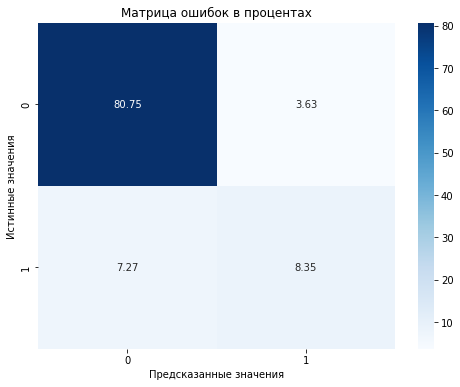

In [92]:
cm = confusion_matrix(target_test, predict)
total_samples = np.sum(cm)
cm_percent = cm / total_samples * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок в процентах')
plt.show()

Из матрицы видно, что модель хорошо предсказывает клиентов, которые хотят остаться, а вот из клиентов, которые хотят уйти,  предсказывает чуть больше половины (собственно, recall = 0,53 это явно демонстирует)

### ROC-кривая

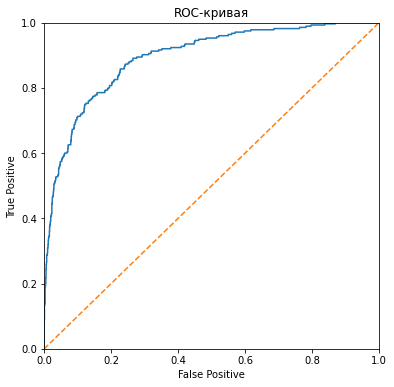

In [93]:
probabilities_test = model_lgbm.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC-кривая')
plt.show()

### Важность признаков:

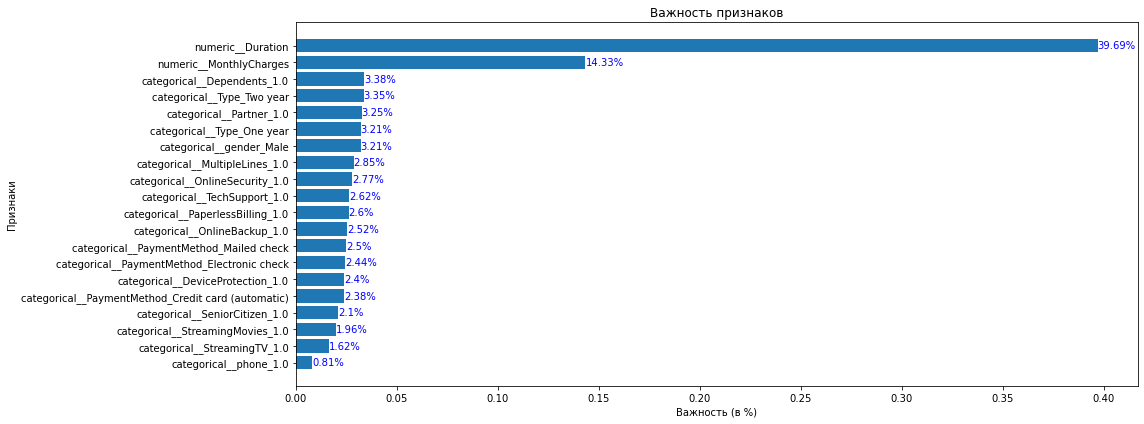

In [94]:
# Извлечение классификатора из конвейера
classifier = model_lgbm.named_steps['lgbmclassifier']

# Получение важности признаков
feature_importance = classifier.feature_importances_

# Получение списка названий признаков
column_names = model_lgbm.named_steps['columntransformer'].get_feature_names_out()

# Создание отсортированного списка признаков и их важностей
sorted_indices = np.argsort(feature_importance)[::1]  # Изменение порядка сортировки
sorted_column_names = [column_names[i] for i in sorted_indices]
sorted_feature_importance = feature_importance[sorted_indices]

# Нормализация значений важности
normalized_feature_importance = sorted_feature_importance / np.sum(sorted_feature_importance)

# Создание графика
plt.figure(figsize=(16, 6))
plt.barh(sorted_column_names, normalized_feature_importance)
plt.xlabel('Важность (в %)')
plt.ylabel('Признаки')
plt.title('Важность признаков')

# Добавление подписей значений столбцов в процентах
for i, v in enumerate(normalized_feature_importance):
    plt.text(v, i, f'{round(v * 100, 2)}%', color='blue', va='center')

plt.tight_layout()
plt.show()

Из графика видно, что больше всего на результат влияют длительность пользования услугами (чем дольше клиент пользуется услугами - тем меньше шансов, что он уйдет) и стоимость (чем дороже услуги - тем больше вероятность чем клиент уйдет). <br />
То есть, в приоритете - привычка и выгода.

### Shap-анализ

Получение датафрейма, который приходит в классификатор:

In [95]:
smote_input_df = model_lgbm.named_steps['columntransformer'].transform(features_train)
lgbm_input_df = model_lgbm.named_steps['smote'].fit_resample(smote_input_df, target_train)[0]

Получение новых имен столбцов:

In [96]:
column_transformer = model_lgbm.named_steps['columntransformer']
numeric_features_names = column_transformer.transformers_[0][2]
categorical_features_names = column_transformer.named_transformers_['categorical'].get_feature_names_out(cat_columns)
new_column_names = list(numeric_features_names) + list(categorical_features_names)

Присвоение новых имен столбцов:

In [97]:
lgbm_input_df = pd.DataFrame(lgbm_input_df, columns=new_column_names)

Собственно, анализ:

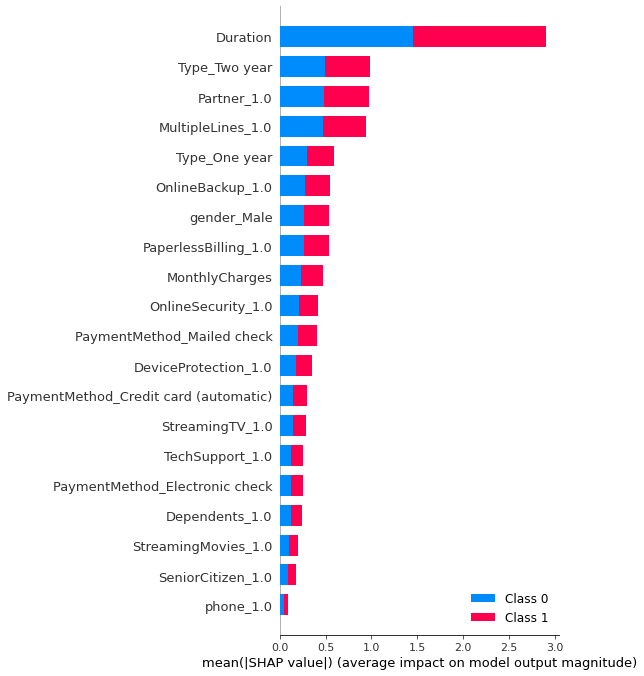

In [98]:
shap_test = shap.TreeExplainer(classifier).shap_values(lgbm_input_df)
shap.summary_plot(shap_test, lgbm_input_df, max_display=25, auto_size_plot=True)

Длительность и тут в лидерах, а вот ежемесячный платеж сильно отстал

### **Итоги тестирования**

1.Проведено тестирование лучшей из рассмотренных моделей: LightGBM c гиперпараметрами:
- 'n_estimators': 160,
- 'max_depth': 15, 
- 'learning_rate': 0.076, 
- 'boosting_type': 'gbdt'<br /><br />
Значения метрик лучшей модели на тестовой выборке:
- AUC-ROC:	 0.89
- F1:		 0.60
- accuracy:	 0.89
- precision:	 0.70
- recall:		 0.53
2. Построены матрица ошибок и график ROC-кривой
3. Проанализированы признаки, на которых обучалась модель, на предмет их важности. Самыми вахными оказались длительность пользования услугами (39,69%) и ежемесячный платеж (14,33%). Shap-анализ также показывает важность типа контракта

## **Эксперимент**

Попробуем прописать дату закрытия далёкой датой для незакрытых контрактов, и зададим им длительность обслуживания 10000 дней

### Подготовка

In [99]:
try:
    contracts_exp = pd.read_csv('datasets/contract_new.csv')
except:
    contracts_exp = pd.read_csv('/datasets/contract_new.csv')

In [100]:
def is_closed(row):
    if row['EndDate'] == 'No':
        row['Closed'] = False
        
    else:
        row['Closed'] = True

    return row    

In [101]:
contracts_exp = contracts_exp.apply(is_closed, axis=1)

In [102]:
contracts_exp['BeginDate'] = pd.to_datetime(contracts_exp['BeginDate'])

In [103]:
contracts_exp['EndDate'] = contracts_exp['EndDate'].replace('No', '2222-02-01')
contracts_exp['EndDate'] = pd.to_datetime(contracts_exp['EndDate'])

In [104]:
contracts_exp['Duration'] = (contracts_exp['EndDate'] - contracts_exp['BeginDate']).dt.days

In [105]:
contracts_exp

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Closed,Duration
0,7590-VHVEG,2020-01-01,2222-02-01,Month-to-month,Yes,Electronic check,$29.85,31.04,False,73810
1,5575-GNVDE,2017-04-01,2222-02-01,One year,No,Mailed check,$56.95,2071.84,False,74815
2,3668-QPYBK,2019-10-01,2222-02-01,Month-to-month,Yes,Mailed check,$53.85,226.17,False,73902
3,7795-CFOCW,2016-05-01,2222-02-01,One year,No,Bank transfer (automatic),$42.30,1960.6,False,75150
4,9237-HQITU,2019-09-01,2222-02-01,Month-to-month,Yes,Electronic check,$70.70,353.5,False,73932
...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2222-02-01,One year,Yes,Mailed check,$84.80,2035.2,False,74509
7039,2234-XADUH,2014-02-01,2222-02-01,One year,Yes,Credit card (automatic),$103.20,7430.4,False,75970
7040,4801-JZAZL,2019-03-01,2222-02-01,Month-to-month,Yes,Electronic check,$29.60,325.6,False,74116
7041,8361-LTMKD,2019-07-01,2222-02-01,Month-to-month,Yes,Mailed check,$74.40,520.8,False,73994


In [106]:
def aligner(row):
    if row['Closed'] == False: 
        row['Duration'] = 10000
    return row    

In [107]:
contracts_exp = contracts_exp.apply(aligner, axis=1)

In [108]:
contracts_exp['PaperlessBilling'] = contracts_exp['PaperlessBilling'].map({'Yes': True, 'No': False})
contracts_exp['PaperlessBilling'].dtypes

dtype('bool')

In [109]:
contracts_exp.set_index('customerID', inplace=True)

In [110]:
data_exp = contracts_exp.join([personal,internet,phone])

In [111]:
data_exp['InternetService'] = data_exp['InternetService'].fillna('No internet')

In [112]:
data_exp = data_exp.fillna(value=False)

In [113]:
features_exp = data_exp.drop('Closed', axis = 1)
target_exp = data_exp['Closed']

In [114]:
features_exp_train, features_exp_test, target_exp_train, target_exp_test = train_test_split(
    features_exp, target_exp, test_size=0.25, random_state=220523, stratify = target)

In [115]:
features_exp_train = features_exp_train.reset_index(drop=True)
features_exp_test = features_exp_test.reset_index(drop=True)
target_exp_train = target_exp_train.reset_index(drop=True)
target_exp_test = target_exp_test.reset_index(drop=True)

In [116]:
features_exp_train = features_exp_train[low_corr]

In [117]:
features_exp_test = features_exp_test[low_corr]

### Моделирование

Попробуем модель LightGBM на экспериментальных данных:

In [118]:
pipeline = make_pipeline(
    ColumnTransformer([
        ('numeric', StandardScaler(), numeric), 
        ('categorical', OneHotEncoder(drop='first', handle_unknown='error', sparse=False), cat_columns)
    ]),
    SMOTE(random_state=220523),
    LGBMClassifier(random_state=220523)
)

In [119]:
parameters = {
            'lgbmclassifier__n_estimators': [40, 80, 120, 160,200],
            'lgbmclassifier__max_depth': [5, 10, 15, 20],
            'lgbmclassifier__boosting_type': ['gbdt','goss'],
            'lgbmclassifier__learning_rate': np.logspace(-3, 0, 100) # Диапазон значений от 0.001 до 1
}

In [120]:
scoring_metrics = ['roc_auc', 'f1', 'accuracy', 'precision', 'recall']
rs = RandomizedSearchCV(pipeline, 
                        parameters, 
                        n_iter = 5, 
                        scoring = scoring_metrics,
                        refit='roc_auc',
                        cv = 5, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=220523)
rs.fit(features_train, target_train)
model_lgbm_exp = rs.best_estimator_
model_lgbm_exp.params = rs.best_params_
result_lgbm_exp = rs.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [121]:
print('Значения метрик:')
print('AUC-ROC:\t {:.2f}'.format(rs.cv_results_['mean_test_roc_auc'][rs.best_index_]))
print('F1:\t\t {:.2f}'.format(rs.cv_results_['mean_test_f1'][rs.best_index_]))
print('accuracy:\t {:.2f}'.format(rs.cv_results_['mean_test_accuracy'][rs.best_index_]))
print('precision:\t {:.2f}'.format(rs.cv_results_['mean_test_precision'][rs.best_index_]))
print('recall:\t\t {:.2f}'.format(rs.cv_results_['mean_test_recall'][rs.best_index_]))

Значения метрик:
AUC-ROC:	 0.86
F1:		 0.52
accuracy:	 0.87
precision:	 0.62
recall:		 0.44


In [122]:
print('Гиперпараметры лучшей модели:\n', model_lgbm_exp.params)

Гиперпараметры лучшей модели:
 {'lgbmclassifier__n_estimators': 160, 'lgbmclassifier__max_depth': 15, 'lgbmclassifier__learning_rate': 0.07564633275546291, 'lgbmclassifier__boosting_type': 'gbdt'}


In [123]:
print('Значения метрик:')
print('AUC-ROC:\t {:.2f}'.format(result_lgbm_exp))
predict_exp = model_lgbm.predict(features_exp_train)
print('F1:\t\t {:.2f}'.format(f1_score(target_exp_train,predict_exp)))
print('accuracy:\t {:.2f}'.format(accuracy_score(target_exp_train,predict_exp)))
print('precision:\t {:.2f}'.format(precision_score(target_exp_train,predict_exp)))
print('recall:\t\t {:.2f}'.format(recall_score(target_exp_train,predict_exp)))

Значения метрик:
AUC-ROC:	 0.86
F1:		 0.86
accuracy:	 0.96
precision:	 1.00
recall:		 0.76


AUC-ROC достигает невероятного 1.0, остальные метрики тоже сильно выросли

Посмотрим на матрицу ошибок:

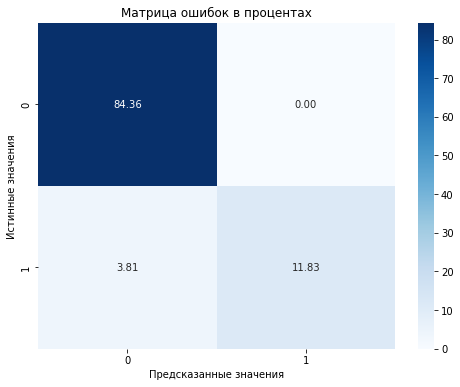

In [124]:
cm_exp = confusion_matrix(target_exp_train, predict_exp)
total_samples = np.sum(cm_exp)
cm_percent = cm_exp / total_samples * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок в процентах')
plt.show()

Результаты значительно улучшились: recall вырос до 76%!<br />

### Проверка на тестовой выборке

In [125]:
probabilities_test = model_lgbm_exp.predict_proba(features_exp_test)
probabilities_one_test = probabilities_test[:, 1]
print('AUC-ROC: {:.2f}'.format(roc_auc_score(target_exp_test, probabilities_one_test)))

AUC-ROC: 1.00


In [126]:
print('Значения метрик:')
print('AUC-ROC:\t {:.2f}'.format(roc_auc_score(target_exp_test, probabilities_one_test)))
predict = model_lgbm_exp.predict(features_exp_test)
print('F1:\t\t {:.2f}'.format(f1_score(target_exp_test,predict)))
print('accuracy:\t {:.2f}'.format(accuracy_score(target_exp_test,predict)))
print('precision:\t {:.2f}'.format(precision_score(target_exp_test,predict)))
print('recall:\t\t {:.2f}'.format(recall_score(target_exp_test,predict)))

Значения метрик:
AUC-ROC:	 1.00
F1:		 0.70
accuracy:	 0.93
precision:	 1.00
recall:		 0.53


Странные значения... Посмотрим матрицу ошибок....

### Матрица ошибок

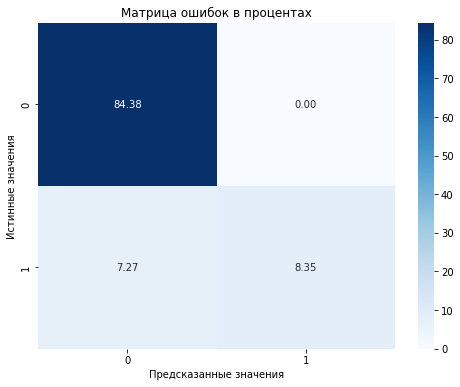

In [127]:
cm = confusion_matrix(target_exp_test, predict)
total_samples = np.sum(cm)
cm_percent = cm / total_samples * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок в процентах')
plt.show()

### ROC-кривая

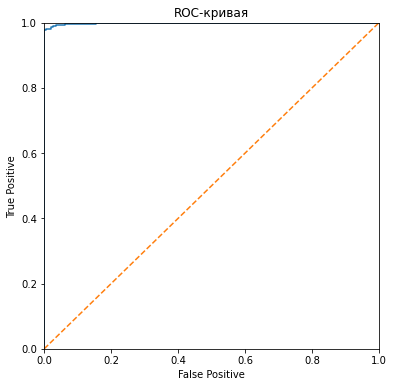

In [128]:
probabilities_test = model_lgbm.predict_proba(features_exp_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_exp_test, probabilities_one_test) 
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC-кривая')
plt.show()

### Вывод

ROC-AUC = 1 - признак утечки. Такой модели доверять нельзя

## **Вопросы**

Больше вопросов нет :)

## **Отчёт**

### Поставленная задача

Для прогнозирования оттока клиентов оператора связи «Ниединогоразрыва.ком» на основании персональных данных о некоторых клиентах, информации об их тарифах и договорах требуется построить модель со значением метрики ROC-AUC >= 0.85.

### Трудности в решении задачи

**При решении задачи необходимо было решить следующие проблемные вопросы:**

***1. Исходная информация содержалась в 4 разных наборах данных с разным количеством записей:***
- данные о контрактах, 
- данные о пользователях, 
- данные об услугах телефонии,
- данные об услугах интернета.

Для решения этой проблемы: 
- наборы данных были объединены в один общий,
- введены признаки 'inet' и 'phone', показывающие включение в контракт интернет-услуг и услуг голосовой связи соответственно
- заполнены образовавшиеся при объединении пустые значения признаков

***2. Поле "Дата закрытия контракта" содержало смешанную информацию:***
- о дате закрытия, если контракт был закрыт, 
- слово "No", если контракт был открыт.

Для решения этой проблемы:
- из поля  **'EndDate'** (Дата закрытия контракта) был получен целевой признак **'Closed'**, со значениями *True*, 
если в поле **'EndDate'** стояла дата закрытия, и *False*, если в нем стояло 'No';
- значения 'No' были заменены на дату получения выборки: 1 февраля 2020 года.

**3. Часть признаков имело высокую корреляцию между собой.**

Для решения этой проблемы из данных для моделирования были исключены признаки, вызывающие высокую корреляцию.

### План работы

Был разработан план решения задачи:

1.	**Исследовательский анализ**<br />
        1.1. Загрузка данных<br />
        1.2. Анализ каждого из датасетов<br />
        1.3. Приведение типов<br />
        1.4. Создание необходимых столбцов<br />
2.	**Предобработка данных**<br />
    2.1. Объединение датасетов<br /> 
    2.2. Заполнение пустых значений<br />
    2.3. Выделение признаков и целевого признака<br />
    2.4. Разбивка на обучающую и тестовую выборки<br />
    2.5. Отбор признаков с низкой корелляцией<br />
    2.6. Масштабирование числовых признаков<br />
    2.7. OHE категориальных признаков<br />
    2.8. Устранение дисбаланса классов<br />
3.	**Моделирование**<br />
    3.1. Выбор моделей <br />
    3.2. Выбор дополнительных метрик<br />
    3.3. Подбор гиперпараметров<br />
    3.4. Моделирование<br />
    3.5. Выбор наилучшей модели с учётом ROC-AUC и дополнительных метрик на кросс-валидации<br />
4.	**Тестирование**<br />
    4.1. Тестирование наилучшей модели на тестовой выборке<br />
    4.2. Исследование важности признаков лучшей модели<br />
    4.3. Построение матрицы ошибок<br />
5.	**Отчёт**


За время работы над проектом план немного изменился:<br />
пункты "Масштабирование числовых признаков", "OHE категориальных признаков" и 
"Устранение дисбаланса классов" <br />
были выполнены в разделе "Моделирование", <br />
поскольку соответствующие им действия были включены в состав разработанных моделей.

В остальном, все пункты плана были выполнены.

### Ключевые шаги в решении задачи

Ключевыми шагами в решении задачи стали:

**1. Исследовательский анализ**<br /><br />
При проведении исследовательского анализа была изучена структура и целостность данных каждого из наборов данных, 
а так же созданы дополнительные столбцы, необходимые для решения задачи:
- "Closed", хранящий информацию о том, закрыт контракт или нет - целевой признак задачи;
- "Duration", хранящий длительность контракта в днях;
- "inet", содержащий информацию о том, подключены ли пользователю интернет-услуги;
- "phone", содержащий информацию о том, подключены ли пользователю услуги голосовой связи.<br /><br />
Также в каждом из наборов данные были приведены к соответствующим им типам.<br />

**2. Предобработка данных**<br /><br />
На этом шаге были выполнены следующие действия:
- объединены четыре набора данных в один, 
- выделена обучающая и тестовая выборка,
- удалены признаки, вызывающие высокую корреляцию.

**3. Моделирование**<br /><br />
На этапе моделирования были созданы модели-пайплайны, состояще из:<br />
- масштабатора **StandardScaler** для числовых признаков,
- кодировщика **OneHotEncoder** для категориальных признаков,
- балансиновщика **SMOTE**, <br />
а так же одной из моделей:<br />
    - **DummyClassifier** (как меры адекватности моделей),
    - **LogisticRegression**,
    - **RandomForest**,
    - **LightGBM**.<br />

Лучший результат показала модель пайплайна с классификатором **LightGBM** с параметрами:
- 'n_estimators': 160,
- 'max_depth': 15,
- 'learning_rate': 0.076,
- 'boosting_type': 'gbdt'<br /><br />
Значения метрик лучшей модели на обучающей выборке:
- AUC-ROC: 0.86
- F1:		 0.52
- accuracy:	 0.87
- precision:	 0.62
- recall:		 0.44

**4.Тестирование**<br /><br />
На этапе тестирования лучшая модель была проверена на тестовой выборке, получены следующие значения метрик:<br />
- AUC-ROC: 0.89
- F1: 0.60
- accuracy: 0.89
- precision: 0.70
- recall: 0.53.<br /><br />
Для данной модели построены матрица ошибок, ROC-кривая, проанализирована важность признаков для модели (самыми важными оказались длительность пользования услугами (39,69%) и ежемесячный платеж (14,33%)).

### Характеристики итоговой модели

Для решения поставленной задачи предлагается следующая модель машинного обучения:<br /><br />
    **Пайплайн**, состоящий из:
1. Масштабатора **StandardScaler** для числовых признаков.
2. Кодировщика **OneHotEncoder** для категориальных признаков с параметрами:
- drop='first';
- handle_unknown='error'; 
- sparse=False.
3. Балансиновщика **SMOTE** с параметром:
- random_state=220523.
4. Классификатора **LightGBMClassifier** с параметрами:
- random_state=220523;
- 'n_estimators'=160;
- 'max_depth'=15;
- 'learning_rate'=0.076;
- 'boosting_type'='gbdt'.


Значения метрик данной модели на обучающей выборке:
- AUC-ROC: 0.86
- F1:		 0.52
- accuracy:	 0.87
- precision:	 0.62
- recall:		 0.44

Значения метрик данной модели на тестовой выборке:
- AUC-ROC: 0.89
- F1: 0.60
- accuracy: 0.89
- precision: 0.70
- recall: 0.53.<br /><br />

### Список признаков, использованных для обучения итоговой модели, описание их предобработки

***При обучении данной модели были использованы следующие признаки:***
1. **'Type'** - 'Тип контракта'.<br /><br />
2. **'PaperlessBilling'** - 'Безбумажное выставление счетов'. <br />Данные столбца приведены к типу bool.<br /><br />
3. **'PaymentMethod'** - 'Способ оплаты'.<br /><br />
4. **'MonthlyCharges'** - 'Средний ежемесячный платеж'.<br /><br />
5. **'Duration'** - 'Длительность контракта в днях'. <br />Вычислен вычитанием  полей  **'EndDate'** (Дата закрытия контракта) и **'BeginDate'** (Дата подписания контракта)<br /><br />
6. **'gender'** - 'Пол клиента'.<br /><br />
7. **'SeniorCitizen'** -'Является ли клиент пенсионером'.<br />Данные столбца приведены к типу bool.<br /><br />
8. **'Partner'** -'Состоит ли клиент в браке'. <br />Данные столбца приведены к типу bool.<br /><br />
9. **'Dependents'** - 'Наличие иждевенцев у клиента'.<br /> Данные столбца приведены к типу bool.<br /><br />
10. **'OnlineSecurity'** - 'Подключена блокировка небезопасных сайтов'.<br /> Данные столбца приведены к типу bool.<br /><br />
11. **'OnlineBackup'** - 'Подключено облачное хранилище файлов для резервного копирования данных'.<br />Данные столбца приведены к типу bool. <br /><br />
12. **'DeviceProtection'** - 'Подключен Антивирус'.<br /> Данные столбца приведены к типу bool. <br /><br />
13. **'TechSupport'** - 'Подключен сервис технической поддержки'.<br /> Данные столбца приведены к типу bool.<br /><br />
14. **'StreamingTV'** - 'Подключено стриминговое телевидение'.<br /> Данные столбца приведены к типу bool.<br /><br />
15. **'StreamingMovies'** - 'Подключен каталог фильмов'.<br /> Данные столбца приведены к типу bool.<br /><br />
16. **'phone'** - 'Подключены ли пользователю услуги голосовой связи'.<br /> Искусственный признак, со значениями *True* для всех контрактов, содержащих услуги телефонной связи, и *False* - для всех остальных. <br /><br />
17. **'MultipleLines'** - Подключена ли пользователю услуга многоканальной телефонной линии".<br /> Данные столбца приведены к типу bool.<br /><br />

**Целевой признак:<br />**
- **'Closed'**, хранящий информацию о том, закрыт контракт или нет.<br /> Вычислен из информации в поле  **'EndDate'**

***Не участвовали непосредственно в обучении, но использовались для расчёта других признаков:***


1. **'customerID':** - 'Уникальный идентификатор пользователя<br />.
Использовался для объединения наборов данных<br /><br />
2. **'BeginDate'** - 'Дата подписания контракта'<br />
Использовался при расчёте признака **'Duration'** (Длительность контракта в днях)<br /><br />
3. **'EndDate'**  - 'Дата закрытия контракта' <br />
Использовался при расчёте признаков **'Duration'** и целевого признака **'Closed'**

**Наиболее важным** для результата моделирования является признак **Duration**